In [2]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('text',usetex=True)
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif']=['Verdana']
plt.rcParams.update({'font.size': 15})
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([])
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 150
dpiFig = 300.

import xarray as xr
import numpy as np
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_SDbias, detrend_members

import sys
sys.path.append(base_dir+'train/kerastuner_hpsearch/hp_results/')
from tfexp_hp import get_hp

Num GPUs Available:  0


### Load standardized E3SM

In [4]:
EXP_NAME_DATA = 'exp_data'
hps_data = get_hp(EXP_NAME_DATA)
print('Training Members: '+str(hps_data['train_mems']))
print('Validation Member: '+str(hps_data['val_mems'][0]))
print('Testing Member: '+str(hps_data['test_mems'][0]))
print('Lead: '+str(hps_data['LEAD']))
print('Region: '+str(hps_data['region'][0])+'N x '+str(hps_data['region'][1])+'E')

_, _, X1test, _, _, Y1test, inew = split_SDbias(trainmems = hps_data['train_mems'],
                                                  valmem = hps_data['val_mems'][0],
                                                  testmem = hps_data['test_mems'][0],
                                                  months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                  lead = hps_data['LEAD'])

X1test = X1test.reshape((X1test.shape[0],X1test.shape[1]*X1test.shape[2]))

EXP_NAME = 'exp_2.BO'
hps = get_hp(EXP_NAME)
GLOBAL_SEED = hps['GLOBAL_SEED']
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

BATCH_SIZES = hps['BATCH_SIZES']

Training Members: ['0101', '0111', '0121', '0131', '0141', '0151', '0161', '0171', '0181']
Validation Member: 0191
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E
files do not exist - loading data & saving


### Test NN

235/235 [==============================] - 0s 1ms/step


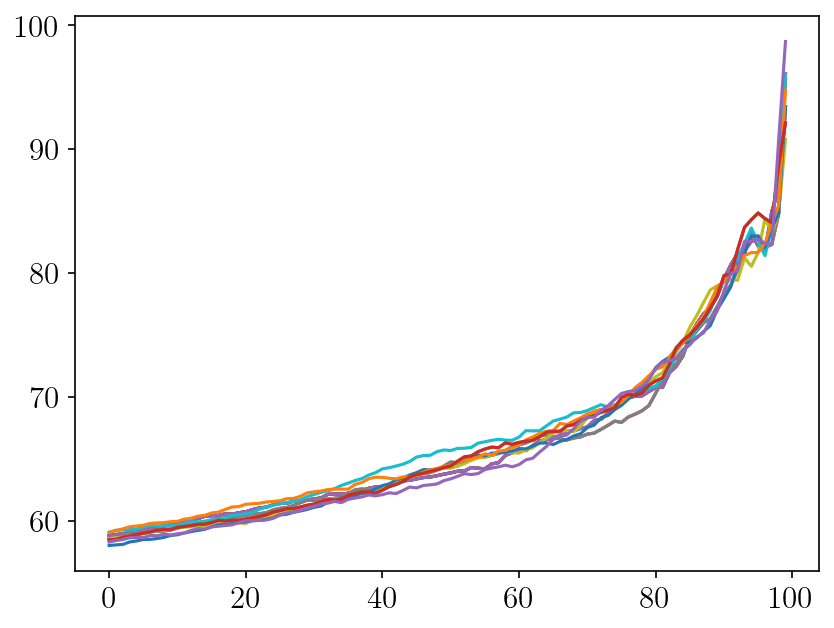

In [10]:
#----- SET UP & TRAIN NN -----
acc_all = []
SEED = 0
# trial_ids = ['017','019','020','018','099'] # for exp_1
for BATCH_SIZE in BATCH_SIZES:
    for b_hps in range(5):
        annfi_name = 'ann_60Eshift_'+EXP_NAME+'_'+str(BATCH_SIZE)+'_modelnum'+str(b_hps+1)+'outof5_seed'+str(SEED)+'.h5'
        ann = tf.keras.models.load_model(base_dir+'train/kerastuner_hpsearch/hp_results/hp_exp'+EXP_NAME[4]+'.BO_models/'+annfi_name)
        
        pred = ann.predict(X1test)
        acc = []
        predconf = np.max(pred,axis=-1)
        predval  = np.argmax(pred,axis=-1)
    
        for q in range(100):
            iconf = np.where(predconf >= np.percentile(predconf,q=q))
            icorr = np.where(predval[iconf] == Y1test[iconf])
            
            acc.append((len(icorr[0])/len(iconf[0]))*100)
        plt.plot(acc)
        
        acc_all.append(acc)
    
    np.save(base_dir+'train/kerastuner_hpsearch/hp_results/hp_exp'+EXP_NAME[4]+'.BO_results/confvsacc_ann1_60Eshift_'+EXP_NAME+'_'+str(BATCH_SIZE)+'_top5models_seed'+str(SEED)+'.npy', acc_all, allow_pickle=True)

In [6]:
# data for panel (a)
ddir_og = base_dir+'test/confvsacc/'
EXP_NAME_OG = 'exp2'
finame = 'confvsacc_ann1_60Eshift_'+EXP_NAME_OG+'.npy'
ann1_acc_og = np.load(ddir_og+finame)
ann1_acc_og[ann1_acc_og==0] = np.nan
# --- ANN1
ann1_acc_og_avg = np.nanmedian(ann1_acc_og,axis=0)
ann1_acc_og_min = np.nanmin(ann1_acc_og,axis=0)
ann1_acc_og_max = np.nanmax(ann1_acc_og,axis=0)

SEED = 0
ann1_acc_kt_all = []
for BATCH_SIZE in BATCH_SIZES:
    # data from Keras Tuner HP search
    ddir_kt = base_dir+'train/kerastuner_hpsearch/hp_results/hp_exp'+EXP_NAME[4]+'.BO_results/'
    
    finame = 'confvsacc_ann1_60Eshift_'+EXP_NAME+'_'+str(BATCH_SIZE)+'_top5models_seed'+str(SEED)+'.npy'
    ann1_acc_kt = np.load(ddir_kt+finame)
    ann1_acc_kt[ann1_acc_kt==0] = np.nan
    ann1_acc_kt_all.extend(ann1_acc_kt)
ann1_acc_kt_avg = np.nanmedian(ann1_acc_kt_all,axis=0)
ann1_acc_kt_min = np.nanmin(ann1_acc_kt_all,axis=0)
ann1_acc_kt_max = np.nanmax(ann1_acc_kt_all,axis=0)

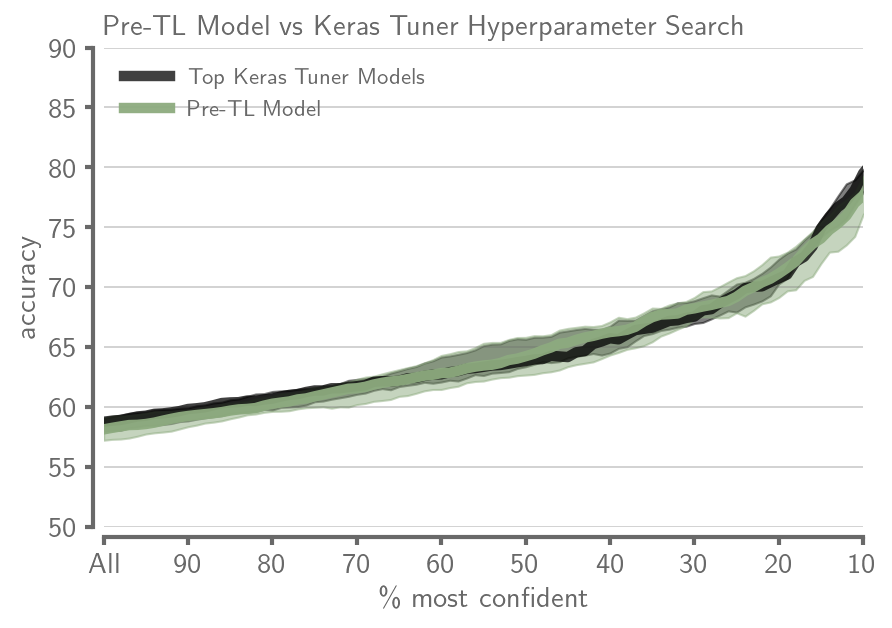

In [7]:
ktresultscolor = 'k'
preTLcolor = (141/255,171/255,127/255,1.)
FS = 14

fig = plt.figure(figsize=(6,4))
ax = fig.subplot_mosaic('''
                        A
                        ''')
plt.tight_layout(w_pad=1,h_pad=3.5)
loc = 'A'
adjust_spines(ax[loc], ['left', 'bottom'])
ax[loc].spines['top'].set_color('none')
ax[loc].spines['right'].set_color('none')
ax[loc].spines['left'].set_color('dimgrey')
ax[loc].spines['bottom'].set_color('dimgrey')
ax[loc].spines['left'].set_linewidth(2)
ax[loc].spines['bottom'].set_linewidth(2)
ax[loc].tick_params('both',length=4,width=2,which='major',color='dimgrey')
ax[loc].yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)
ax[loc].set_ylim(50,90)
ax[loc].set_xlim(0,90)
ax[loc].set_ylabel('accuracy',fontsize=FS,color='dimgrey')
ax[loc].set_yticks(np.arange(50,95,5),labels=np.arange(50,95,5),fontsize=FS,color='dimgrey')
ax[loc].set_xticks(np.arange(0,100,10),['All',90,80,70,60,50,40,30,20,10],fontsize=FS,color='dimgrey')
ax[loc].set_xlabel('\% most confident',fontsize=FS,color='dimgrey')

ax['A'].fill_between(np.arange(0,100,1),ann1_acc_kt_min,ann1_acc_kt_max,color=ktresultscolor, alpha=0.5)
ax['A'].plot(ann1_acc_kt_avg, '-', color=ktresultscolor, alpha=0.75,linewidth=5,label='Top Keras Tuner Models')

ax['A'].fill_between(np.arange(0,100,1),ann1_acc_og_min,ann1_acc_og_max,color=preTLcolor, alpha=0.5)
ax['A'].plot(ann1_acc_og_avg, '-', color=preTLcolor, alpha=0.95,linewidth=5,label='Pre-TL Model')

ax['A'].set_title('Pre-TL Model vs Keras Tuner Hyperparameter Search',fontsize=FS,color='dimgrey', loc='left')
ax['A'].legend(frameon=False, fontsize=FS-3, labelcolor='dimgrey', loc='upper left',ncol=1)

plt.show()